In [52]:
import pandas as pd
from textblob import TextBlob
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
import shap
import joblib

In [53]:
df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\Infinity AI\Assignemnt 1\customer_support_priority_classifier\data\raw\customer_support_tickets.csv')

Preprocessing

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [55]:
df.isnull().sum()

Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

In [56]:
df.drop(columns=[
    'Resolution',
    'Time to Resolution',
    'Customer Satisfaction Rating',
    'Ticket ID',
    'Customer Name',
    'Customer Email'
], inplace=True)

In [57]:
df.head()

,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Ticket Priority,Ticket Channel,First Response Time
0,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,Critical,Social media,2023-06-01 12:15:36
1,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,Critical,Chat,2023-06-01 16:45:38
2,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Low,Social media,2023-06-01 11:14:38
3,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Low,Social media,2023-06-01 07:29:40
4,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,Low,Email,2023-06-01 00:12:42


In [58]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [59]:
df['Ticket Priority'].value_counts(normalize=True)

Ticket Priority
Medium      0.258826
Critical    0.251387
High        0.246192
Low         0.243594
Name: proportion, dtype: float64

In [60]:
print(df['Ticket Description'].head())

0    I'm having an issue with the {product_purchase...
1    I'm having an issue with the {product_purchase...
2    I'm facing a problem with my {product_purchase...
3    I'm having an issue with the {product_purchase...
4    I'm having an issue with the {product_purchase...
Name: Ticket Description, dtype: object


In [ ]:
df['Ticket Description'] = (
    df['Ticket Description']
    .str.replace(r'\{.*?\}', '', regex=True)  
    .str.replace(r'\\+', '', regex=True)      
    .str.replace(r'\s+', ' ', regex=True)     
    .str.strip()                              
)

In [62]:
print(df['Ticket Description'].head())

0    I'm having an issue with the . Please assist. ...
1    I'm having an issue with the . Please assist. ...
2    I'm facing a problem with my . The is not turn...
3    I'm having an issue with the . Please assist. ...
4    I'm having an issue with the . Please assist. ...
Name: Ticket Description, dtype: object


In [ ]:
# NLP Preprocessing
df['Ticket Description'] = (
    df['Ticket Description']
    .str.lower() 
    .str.replace(r"([^\w\s]|(?<!\w)'(?!\w))", '', regex=True)  
    .str.replace(r'\s+', ' ', regex=True) 
    .str.strip() 
)

In [64]:
print(df['Ticket Description'].head())

0    im having an issue with the please assist your...
1    im having an issue with the please assist if y...
2    im facing a problem with my the is not turning...
3    im having an issue with the please assist if y...
4    im having an issue with the please assist note...
Name: Ticket Description, dtype: object


In [65]:
# ordinal encode
priority_map = {'Low': 0, 'Medium': 1, 'High': 2, 'Critical': 3}
df['Ticket Priority'] = df['Ticket Priority'].map(priority_map)
print(df['Ticket Priority'].value_counts())

Ticket Priority
1    2192
3    2129
2    2085
0    2063
Name: count, dtype: int64


In [66]:
# one hot encoding
df = pd.get_dummies(df, columns=['Ticket Type', 'Ticket Status','Ticket Channel', 'Customer Gender'],drop_first=True)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [67]:
# Date Handling
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])
df['purchase_year'] = df['Date of Purchase'].dt.year
df['purchase_month'] = df['Date of Purchase'].dt.month
df.drop(columns=['Date of Purchase'], inplace=True)

df['First Response Time'] = pd.to_datetime(df['First Response Time'], errors='coerce')

In [68]:
df.head()

,Customer Age,Product Purchased,Ticket Subject,Ticket Description,Ticket Priority,First Response Time,Ticket Type_Cancellation request,Ticket Type_Product inquiry,Ticket Type_Refund request,Ticket Type_Technical issue,Ticket Status_Open,Ticket Status_Pending Customer Response,Ticket Channel_Email,Ticket Channel_Phone,Ticket Channel_Social media,Customer Gender_Male,Customer Gender_Other,purchase_year,purchase_month
0,32,GoPro Hero,Product setup,im having an issue with the please assist your...,3,2023-06-01 12:15:36,0,0,0,1,0,1,0,0,1,0,1,2021,3
1,42,LG Smart TV,Peripheral compatibility,im having an issue with the please assist if y...,3,2023-06-01 16:45:38,0,0,0,1,0,1,0,0,0,0,0,2021,5
2,48,Dell XPS,Network problem,im facing a problem with my the is not turning...,0,2023-06-01 11:14:38,0,0,0,1,0,0,0,0,1,0,1,2020,7
3,27,Microsoft Office,Account access,im having an issue with the please assist if y...,0,2023-06-01 07:29:40,0,0,0,0,0,0,0,0,1,0,0,2020,11
4,67,Autodesk AutoCAD,Data loss,im having an issue with the please assist note...,0,2023-06-01 00:12:42,0,0,0,0,0,0,1,0,0,0,0,2020,2


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Customer Age                             8469 non-null   int64         
 1   Product Purchased                        8469 non-null   object        
 2   Ticket Subject                           8469 non-null   object        
 3   Ticket Description                       8469 non-null   object        
 4   Ticket Priority                          8469 non-null   int64         
 5   First Response Time                      5650 non-null   datetime64[ns]
 6   Ticket Type_Cancellation request         8469 non-null   int64         
 7   Ticket Type_Product inquiry              8469 non-null   int64         
 8   Ticket Type_Refund request               8469 non-null   int64         
 9   Ticket Type_Technical issue              

Feature Engineering

In [ ]:
# Handle First Response Time
df['response_hour'] = df['First Response Time'].dt.hour
df['response_dayofweek'] = df['First Response Time'].dt.dayofweek
df['response_hour'] = df['response_hour'].fillna(df['response_hour'].mode()[0])
df['response_dayofweek'] = df['response_dayofweek'].fillna(df['response_dayofweek'].mode()[0])
df.drop(columns=['First Response Time'], inplace=True)

In [71]:
# Word count and urgency flags
df['desc_word_count'] = df['Ticket Description'].str.split().str.len()
pattern = r'\burgent\b|\basap\b|\bimmediately\b|\bemergency\b|\bnow\b|\bcritical\b'
df['desc_has_urgent'] = df['Ticket Description'].str.contains(pattern, case=False).astype(int)

# Sentiment analysis (if using TextBlob)
df['desc_sentiment'] = df['Ticket Description'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [72]:
save_dir = r'C:\Users\USER\OneDrive\Desktop\Infinity AI\Assignemnt 1\customer_support_priority_classifier\data\cleaned'
df.to_csv(os.path.join(save_dir, 'customer_support_tickets_cleaned.csv'), index=False)

In [73]:
df_cleaned = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\Infinity AI\Assignemnt 1\customer_support_priority_classifier\data\cleaned\customer_support_tickets_cleaned.csv')
df_cleaned.head()

,Customer Age,Product Purchased,Ticket Subject,Ticket Description,Ticket Priority,Ticket Type_Cancellation request,Ticket Type_Product inquiry,Ticket Type_Refund request,Ticket Type_Technical issue,Ticket Status_Open,...,Ticket Channel_Social media,Customer Gender_Male,Customer Gender_Other,purchase_year,purchase_month,response_hour,response_dayofweek,desc_word_count,desc_has_urgent,desc_sentiment
0,32,GoPro Hero,Product setup,im having an issue with the please assist your...,3,0,0,0,1,0,...,1,0,1,2021,3,12.0,3.0,42,0,0.000000e+00
1,42,LG Smart TV,Peripheral compatibility,im having an issue with the please assist if y...,3,0,0,0,1,0,...,0,0,0,2021,5,16.0,3.0,42,0,1.305556e-01
2,48,Dell XPS,Network problem,im facing a problem with my the is not turning...,0,0,0,0,1,0,...,1,0,1,2020,7,11.0,3.0,39,1,2.479167e-01
3,27,Microsoft Office,Account access,im having an issue with the please assist if y...,0,0,0,0,0,0,...,1,0,0,2020,11,7.0,3.0,40,0,2.500000e-01
4,67,Autodesk AutoCAD,Data loss,im having an issue with the please assist note...,0,0,0,0,0,0,...,0,0,0,2020,2,0.0,3.0,53,0,-7.930164e-18


In [ ]:
# Select only numeric features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
X_numeric = df[numeric_features]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]

print(vif_data.sort_values("VIF", ascending=False))

                                    feature        VIF
14                       response_dayofweek  43.556077
15                          desc_word_count  24.768693
0                              Customer Age   9.153392
13                            response_hour   7.064875
1                           Ticket Priority   2.819831
6                        Ticket Status_Open   2.642758
4                Ticket Type_Refund request   2.059301
5               Ticket Type_Technical issue   2.052285
7   Ticket Status_Pending Customer Response   2.040031
8                      Ticket Channel_Email   2.025658
2          Ticket Type_Cancellation request   2.025159
9                      Ticket Channel_Phone   2.023349
10              Ticket Channel_Social media   2.016474
11                     Customer Gender_Male   2.001742
3               Ticket Type_Product inquiry   1.995193
12                    Customer Gender_Other   1.929078
17                           desc_sentiment   1.091167
16        

In [75]:
df.drop(columns=['response_dayofweek', 'desc_word_count'], inplace=True)

In [76]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
X_numeric = df[numeric_features]

vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]

print(vif_data.sort_values("VIF", ascending=False))

                                    feature       VIF
0                              Customer Age  6.394446
13                            response_hour  6.386134
1                           Ticket Priority  2.634299
6                        Ticket Status_Open  2.620276
7   Ticket Status_Pending Customer Response  1.930782
11                     Customer Gender_Male  1.895278
8                      Ticket Channel_Email  1.877984
9                      Ticket Channel_Phone  1.874332
5               Ticket Type_Technical issue  1.861085
4                Ticket Type_Refund request  1.859911
10              Ticket Channel_Social media  1.858339
12                    Customer Gender_Other  1.843060
2          Ticket Type_Cancellation request  1.838289
3               Ticket Type_Product inquiry  1.800358
15                           desc_sentiment  1.085714
14                          desc_has_urgent  1.060329


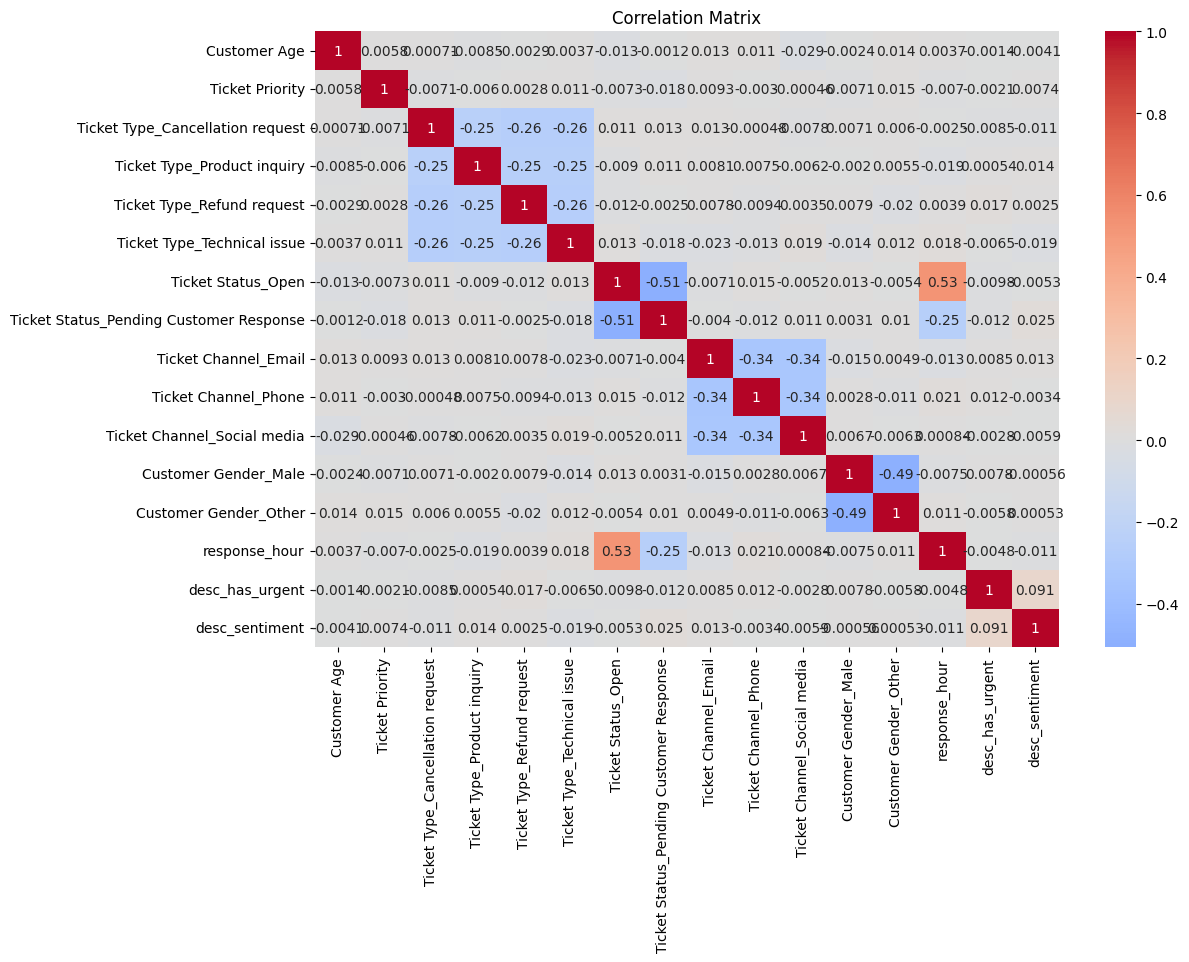

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for numeric features
corr_matrix = X_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

Model Training

In [ ]:
# Define target and features 
X = df.drop(columns=['Ticket Priority', 'Product Purchased', 'Ticket Subject', 'Ticket Description'])
y = df['Ticket Priority']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [80]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Model Evaluation

              precision    recall  f1-score   support

           0       0.19      0.09      0.12       413
           1       0.24      0.42      0.31       438
           2       0.23      0.20      0.21       417
           3       0.24      0.22      0.23       426

    accuracy                           0.23      1694
   macro avg       0.23      0.23      0.22      1694
weighted avg       0.23      0.23      0.22      1694



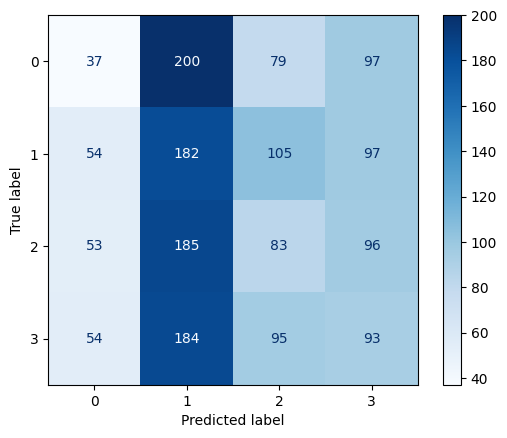

In [82]:
#Linear Regression Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = lr_model.predict(X_test_scaled)

# Evaluation metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap="Blues")


              precision    recall  f1-score   support

           0       0.26      0.24      0.25       413
           1       0.24      0.28      0.26       438
           2       0.25      0.24      0.24       417
           3       0.21      0.19      0.20       426

    accuracy                           0.24      1694
   macro avg       0.24      0.24      0.24      1694
weighted avg       0.24      0.24      0.24      1694



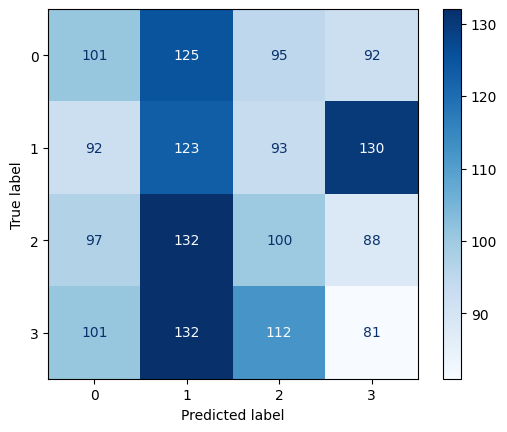

In [83]:
#Random Forest Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = rf_model.predict(X_test)

# Evaluation metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap="Blues")


Hyperparameter Tuning

In [ ]:
#Linear Regression 
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],            
    'penalty': ['l2'],                  
    'solver': ['lbfgs'],                
    'class_weight': [None, 'balanced'] 
}

lr = LogisticRegression(max_iter=1000)

grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)

print("Best LR params:", grid_lr.best_params_)
print("Best LR score:", grid_lr.best_score_)

best_lr_model = grid_lr.best_estimator_

# Evaluate on test set
y_pred = best_lr_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Best LR params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best LR score: 0.25448500026766185
              precision    recall  f1-score   support

           0       0.24      0.20      0.22       413
           1       0.25      0.33      0.29       438
           2       0.22      0.24      0.23       417
           3       0.24      0.19      0.21       426

    accuracy                           0.24      1694
   macro avg       0.24      0.24      0.24      1694
weighted avg       0.24      0.24      0.24      1694



In [85]:
#Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF score:", grid_rf.best_score_)

best_rf_model = grid_rf.best_estimator_

# Evaluate on test set
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best RF params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best RF score: 0.2731904710100136
              precision    recall  f1-score   support

           0       0.24      0.23      0.24       413
           1       0.25      0.28      0.26       438
           2       0.26      0.26      0.26       417
           3       0.22      0.21      0.21       426

    accuracy                           0.24      1694
   macro avg       0.24      0.24      0.24      1694
weighted avg       0.24      0.24      0.24      1694



Feature Importance

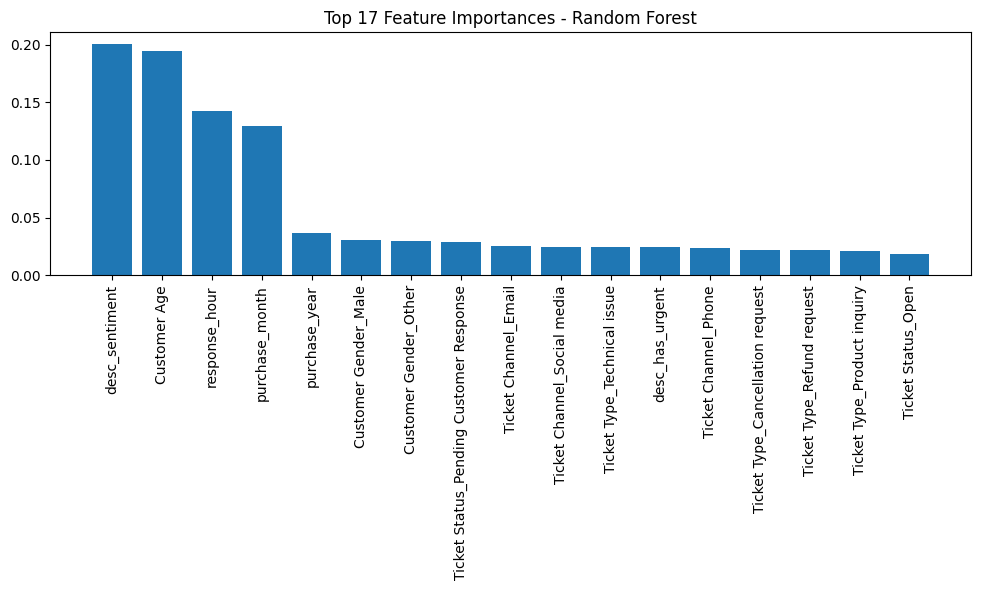

In [86]:
# Get feature importances and their indices
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Use min of 20 or total number of features
top_n = min(20, len(importances))

# Plot
plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Feature Importances - Random Forest")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X.columns[indices[:top_n]], rotation=90)
plt.tight_layout()
plt.show()

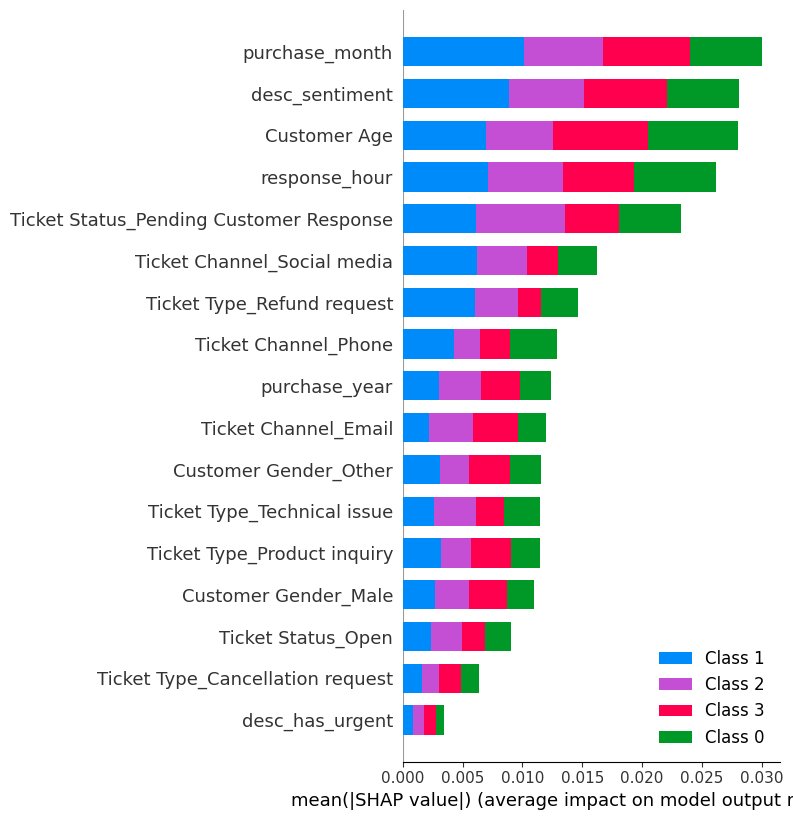

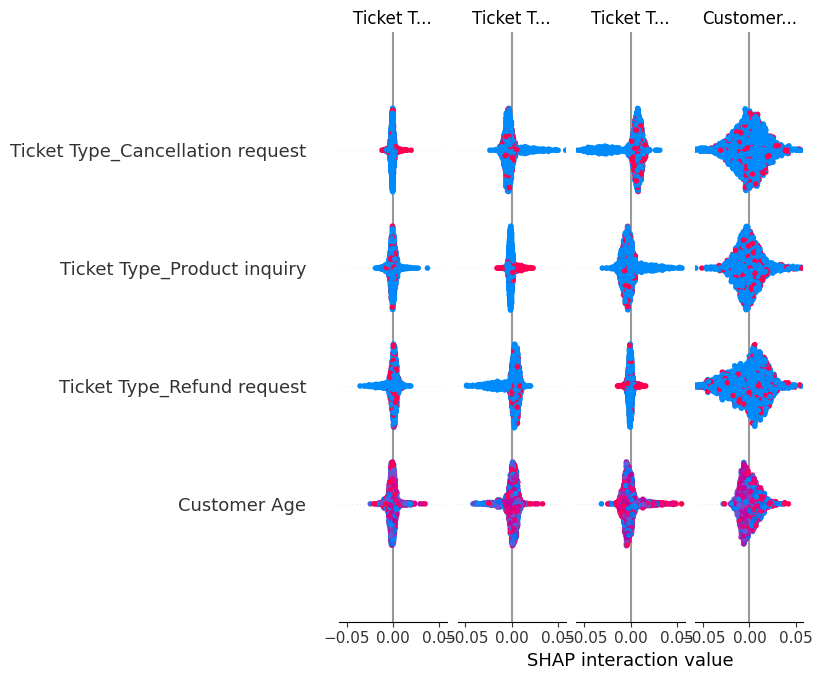

In [ ]:
# Use TreeExplainer for tree-based models like Random Forest
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test, plot_type="bar")     
shap.summary_plot(shap_values, X_test)                     

In [88]:
# Save the model
save_path = r"C:\Users\USER\OneDrive\Desktop\Infinity AI\Assignemnt 1\customer_support_priority_classifier\models"
file_name = "random_forest_model.pkl"

full_path = os.path.join(save_path, file_name)
joblib.dump(best_rf_model, full_path)

print(f"Model saved to: {full_path}")

Model saved to: C:\Users\USER\OneDrive\Desktop\Infinity AI\Assignemnt 1\customer_support_priority_classifier\models\random_forest_model.pkl


Saving model pipeline

In [89]:
models_dir = r'C:\Users\USER\OneDrive\Desktop\Infinity AI\Assignemnt 1\customer_support_priority_classifier\models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

try:
    joblib.dump(scaler, os.path.join(models_dir, 'scaler.pkl'))
    print("StandardScaler saved to models/scaler.pkl")
except NameError:
    print("Error: 'scaler' not found. Ensure StandardScaler was fitted in your notebook.")

# Save the list of final feature columns 
try:
    joblib.dump(X_train.columns.tolist(), os.path.join(models_dir, 'model_features.pkl'))
    print("List of model feature columns saved to models/model_features.pkl")
except NameError:
    print("Error: 'X_train' not found. Ensure X_train was created in your notebook.")

# Save the list of original categorical columns
original_categorical_cols_for_ohe = ['Ticket Type', 'Ticket Status', 'Ticket Channel', 'Customer Gender']
joblib.dump(original_categorical_cols_for_ohe, os.path.join(models_dir, 'original_categorical_cols.pkl'))
print("List of original categorical columns for OHE saved to models/original_categorical_cols.pkl")

# Save the priority mapping dictionary
priority_map_dict = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Critical'}
joblib.dump(priority_map_dict, os.path.join(models_dir, 'priority_map.pkl'))
print("Priority mapping dictionary saved to models/priority_map.pkl")


StandardScaler saved to models/scaler.pkl
List of model feature columns saved to models/model_features.pkl
List of original categorical columns for OHE saved to models/original_categorical_cols.pkl
Priority mapping dictionary saved to models/priority_map.pkl
